## Training Pipeline

### 1. Import data

In [1]:
import glob
import time

# Divide up into cars and notcars
images = glob.glob('../../dataset/**/*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

### 2. Features extraction

In [2]:
import cv2
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Hog Feature and Visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [3]:
color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
spatial_feat=True
hist_feat=True
hog_feat=True

start_time=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
end_time = time.time()
print('It takes ',round(end_time-start_time, 2), 'seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

/home/joseph/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


It takes  118.22 seconds to extract features...


### 3. Feature Normalized

In [4]:
from sklearn.preprocessing import StandardScaler

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

## 4. Split train and test data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)

print(len(X_train[0]))

8460


### 5. Prepare SVM Classifier

In [6]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print('Training takes',round(t2-t, 2), 'seconds')

Training takes 12.88 seconds


### 6. Evaluate on test data

In [7]:
print('Test Accuracy of Linear SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of Linear SVC =  0.9904
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
0.00866 Seconds to predict 10 labels with SVC


### Visualized on TEST_IMAGE

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block,
              spatial_size,
              hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img

/home/joseph/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


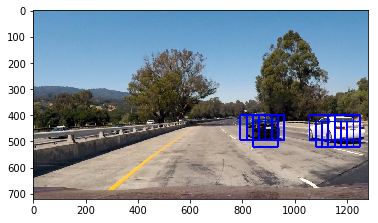

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

img = mpimg.imread('test_images/test1.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

## Store Classifier and Parameters

In [10]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins
     }

with open('model.pk', 'wb') as pFile:
    pickle.dump(data, pFile)